# Working with shapes

Shapes are object created using the package `Shapely` which know about their geometry. They don't need to be associated with a map in any way. We will start with basic shapes, and then use shapes on a map, since shape functions have been included in `cartopy`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shapely.geometry
import shapely.ops
import cartopy
import cartopy.io.shapereader as shpreader

### 0D shapes: Points

In [3]:
point = shapely.geometry.Point(0.2, 1.0)

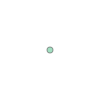

In [4]:
# Notice, the ipython '__repr__' (representation) displays the point as the output
point

In [5]:
# See some of the point attributes
print(point.geom_type)
print(point.area)
print(point.length)
print(point.bounds)
print(point.coords)   # explore this object...
print(point.coords[:])

Point
0.0
0.0
(0.2, 1.0, 0.2, 1.0)
[(0.2, 1.0)]


In [6]:
# A collection of random points...
point1 = shapely.geometry.Point(0.2, 1.0)
point2 = shapely.geometry.Point(0.1, 0.2)
point3 = shapely.geometry.Point(0.5, 0.0)
point4 = shapely.geometry.Point(0.8, 0.5)

In [107]:
# We can see the distance of the points from one another
point2.distance(point1)

0.806225774829855

### 1D shapes: Lines and Rings

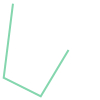

In [110]:
# An ordered sequence of points is a `LineString'
line = shapely.geometry.LineString((point1, point2, point3, point4))
line

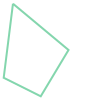

In [113]:
# To make a closed shape, use a `LinearRing'
closed_line = shapely.geometry.LinearRing(line)
closed_line

In [115]:
# Some of the attributes of the LinearRing..
print(closed_line.area)   # no area since it is not 'filled'
print(closed_line.length) # the perimeter of the shape
print(closed_line.bounds) # an xy-plane bounding box

0.0
2.6175595274050085
(0.1, 0.0, 0.8, 1.0)


### 2D shapes, Polygons and Buffers

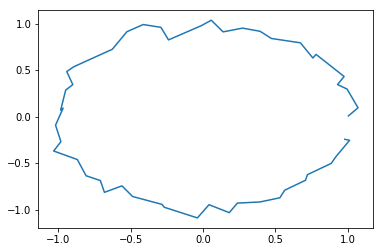

In [137]:
# Let's make a circle, with some noise

N = 50

x = np.cos(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)
y = np.sin(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)

plt.plot(x, y, '-')


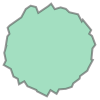

In [138]:
xy = zip(x, y)
poly = shapely.geometry.Polygon(xy)
poly

3.158425498196301
POINT (0.004958529388729344 -0.005200332405322516)
False True


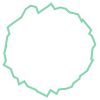

In [139]:
# Some of the Polygon attributes
print(poly.area)
print(poly.centroid)
print(poly.contains(point1), poly.contains(point2))
poly.boundary

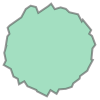

In [145]:
poly

We can also create 2D objects by adding buffers to existing 0D and 1D objects

In [148]:
line.xy

(array('d', [0.2, 0.1, 0.5, 0.8]), array('d', [1.0, 0.2, 0.0, 0.5]))

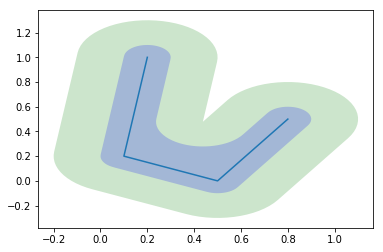

In [164]:
dialated = line.buffer(0.3)
eroded = dialated.buffer(-0.2)

plt.plot(*line.xy)
plt.fill(*dialated.boundary.xy, 'g', alpha=0.2)
plt.fill(*eroded.boundary.xy, 'b', alpha=0.2)

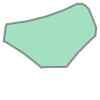

In [165]:
poly.buffer(-.8)

### Operations

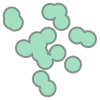

In [194]:
# First, let's make a collection of fat points.
xy = np.random.rand(20, 2)
points = shapely.geometry.MultiPoint(xy).buffer(0.1)
points

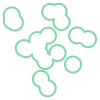

In [195]:
points.boundary

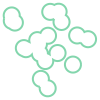

In [196]:
regions = shapely.ops.linemerge(points.boundary)
regions

In [197]:
# make a new line
line2 = shapely.geometry.LineString([(0, 0), (1, 1)])
# find where the polygons from regions intersect with line2
intersections = [poly.intersects(line2) for poly in points]

In [198]:
intersections

[False, False, False, True, False, False]

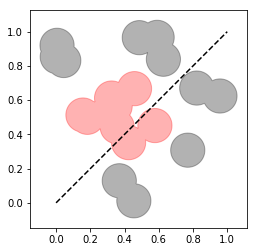

In [200]:
# loop over the polygons in the regions and plot, colored 
# differently if they intersect line1
for poly in points.boundary:
    if poly.intersects(line2):
        color = 'r'
    else:
        color = 'k'
    coords = poly.coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)

# Plot the line also
x, y = zip(*line2.coords[:])
plt.plot(x, y, '--k')
plt.gca().set_aspect(1.0)

## Reading your own shapes and using `cartopy`

You can read in shapefiles outside of the Natural Earth dataset and use them on maps with `cartopy`. Here we look at shipping lanes in the northwest Gulf of Mexico.

We start with a map:

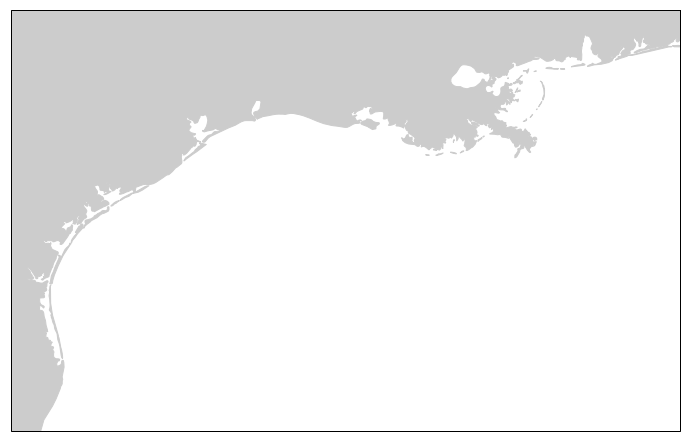

In [25]:
proj = cartopy.crs.LambertConformal()
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-98, -87, 25, 31], cartopy.crs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')

Set up to read in shipping lane data, which is in the `data` directory:

In [26]:
fname = '../data/fairway/fairway.shp'

shape_feature = cartopy.feature.ShapelyFeature(shpreader.Reader(fname).geometries(),
                                cartopy.crs.PlateCarree(), facecolor='none')

Now we can just add the shipping lanes onto our map!

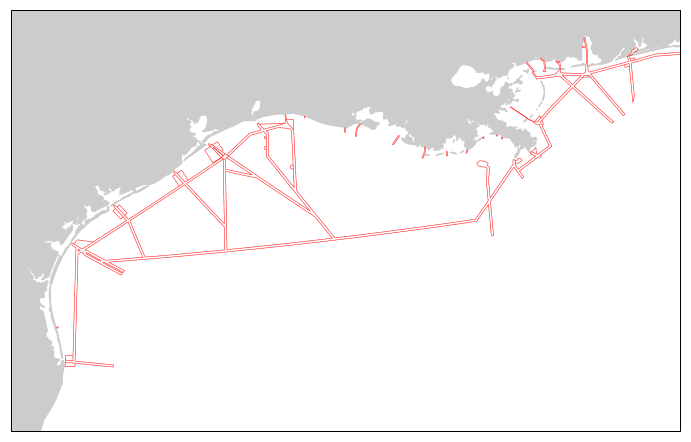

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-98, -87, 25, 31], cartopy.crs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')

# shipping lanes
ax.add_feature(shape_feature, edgecolor='r', linewidth=0.5)

In [201]:
shape_feature.

## Using geometries on a map

Let's work on an example together. What states do you fly over when you fly from LA to NYC?

LAX: 33.9425° N, 118.4081° W (LA)

EWR: 40.6925° N, 74.1686° W (NYC)

What steps do we need to do?

1. Look at a map of states and the start and end points
1. Plot a line between the two locations. BUT it should be along the Great Circle between the points since that is the real shortest distance between two locations on earth and is the likely flight path.
1. See how to loop through states, and access meta data, in order to identify the states to then plot them.

In [28]:
# set up our two end points
lon_lax, lat_lax = [-118.4081, 33.9425]
lon_ewr, lat_ewr = [-74.1686, 40.6925]

In [29]:
# Make map, and overlay states and end points


In [30]:
# Get points between the two end points along the great circle distance

import pyproj  # a fundamental projection package, wrapping the proj4 library. (no plotting)

# here we use the projection we already initiated (proj) to initiate one in the package pyproj
# which connects to the Geodesic, which is the Earth as an approximate sphere
g = pyproj.Geod(proj.proj4_init)

# once we have this geodesic, we can calculate N intermediate points along the great circle 
# connecting the end points
N = 100
xygc = g.npts(lon_lax, lat_lax, lon_ewr, lat_ewr, N)

# use zip to convert (x, y) pairs to a sequence of x and y, respectively.
xgc, ygc = zip(*xygc)

# Now we can just create a list of longitude and latitude for the path, 
# including the start and end points. The endpoints are not included in the output
# of g.npts, which includes only intermediate points.
longc = [lon_lax] + list(xgc) + [lon_ewr]
latgc = [lat_lax] + list(ygc) + [lat_ewr]

# create a shapely LineString out of the lon/lat
flight_path = shapely.geometry.LineString(zip(longc, latgc))

In [211]:
[1] + [2, 3, 4, 5] + [6]

[1, 2, 3, 4, 5, 6]

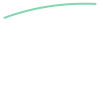

In [202]:
flight_path

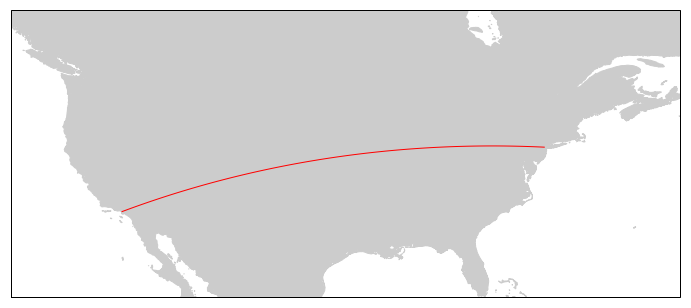

In [224]:
# Add flight path to plot


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.set_extent([-130, -60, 25, 55], cartopy.crs.PlateCarree())

#ax.plot(longc, latgc, '-r', lw=2, transform=cartopy.crs.PlateCarree())
ax.add_geometries([flight_path], cartopy.crs.PlateCarree(), edgecolor='r', facecolor='none')


In [233]:
# Access shapefile metadata along with geometries to loop through states


# deal with shapes differently if want to dig into them more
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(category='cultural', resolution='110m', name=shapename)
reader = shpreader.Reader(states_shp)
states = reader.records()

count = 0
for state in states:
    name = state.attributes['name']
    if name[0] == 'A':
        count += 1
    
    #pass  # comment this out when code is added here
    # Now do stuff with the states
    # Use the state shape with state.geometry, like state.geometry.area
    # Find information about the state with state.attributes

count

4

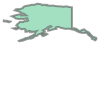

In [244]:
state.geometry

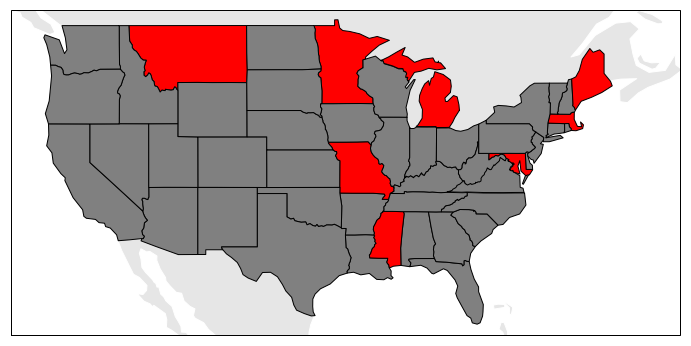

In [243]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection=cartopy.crs.Mercator())
ax.set_extent([-128, -60, 24, 50], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='w')

# # Loop through states and see if they intersect flight path
states_shp = shpreader.natural_earth(category='cultural', resolution='110m', name=shapename)
reader = shpreader.Reader(states_shp)
states = reader.records()

edgecolor = 'black'
for state in states:
    if state.attributes['name'][0] == 'M':
        facecolor='red'
    else:
        facecolor = 'grey'
    ax.add_geometries([state.geometry], cartopy.crs.PlateCarree(),
                       facecolor=facecolor, edgecolor=edgecolor)

In [99]:
ax.add_geometries?

In [268]:
states_shp = shpreader.natural_earth(category='cultural', resolution='110m', name='admin_1_states_provinces_lakes_shp')
reader = shpreader.Reader(states_shp)
states = reader.records()

states_list = [state for state in states]

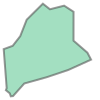

In [277]:
idx = 48
states_list[idx].geometry

In [278]:
states_list[idx].attributes['name']

'Maine'

In [267]:
len(states_list)

3671